# Create image dataset


To install required versions of pytorch


In [ ]:
!pip install torch==1.4+cu100 torchvision==0.5.0+cu100 -f https://download.pytorch.org/whl/torch_stable.html
!nvidia-smi


Map google drive to the machine


In [2]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
import os
os.environ['FASTAI_HOME'] = '/content/drive/My Drive/fastai'

In [1]:
from fastai.vision import *

Where will we store our images


In [4]:
path = Path('/content/drive/My Drive/fastai/data/fruits')

The classes (labels) we have downloaded


In [5]:
classes = ['pear','peach','watermelon','strawberry']

Create destination directories


In [7]:
for c in classes:
  dest_dir = path/c
  dest_dir.mkdir(parents=True,exist_ok=True)

We will need a lot of images, we can use, as a source, APIs from search engines, like google, bing, duckduckgo, etc.

I will use duckduckgo:

Search for images on duck-duck-go, trying to make the search as accurate as possible.

In my case, I'll search for: 

- pear
- peach
- watermelon
- strawberry

Once I have found a lot of images, I'll use Javascript to scrape from the open page (so, scroll down a lot, to have more images on the page). Open the javascript console (Ctrl+Shift+K on my firefox),and write these two lines, one by one:


```
urls = Array.from(document.querySelectorAll('img.tile--img__img.js-lazyload')).map(el=>decodeURIComponent(el.src.split('=')[1])); 

window.open('data:text/csv;charset=utf-8,' + escape(urls.join('\n')));
```

First one creates an array of all URLs of the images on the page.

The other one sends me that array as a CSV file. 


Download all images on CSV Files

In [8]:
for c in classes:
  dest_dir = path/c
  fname = c+".csv"
  filename = path/fname 
  print(filename)
  download_images(filename,dest_dir,max_pics=300)

/content/drive/My Drive/fastai/data/fruits/pear.csv


/content/drive/My Drive/fastai/data/fruits/peach.csv


/content/drive/My Drive/fastai/data/fruits/watermelon.csv


/content/drive/My Drive/fastai/data/fruits/strawberry.csv


Verify images (well downloaded, reducing sizes, etc.)

In [9]:
for c in classes:
  verify_images(path/c, delete=True, max_size=500)

In [6]:
np.random.seed(42)
data = ImageDataBunch.from_folder(path, train=".", valid_pct=0.2, ds_tfms=get_transforms(),
                                  size=224, num_workers=8).normalize(imagenet_stats)

In [7]:
data.classes

['peach', 'pear', 'strawberry', 'watermelon']

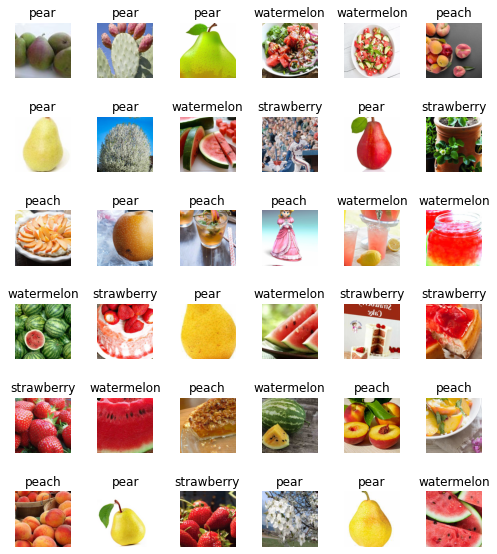

In [8]:
data.show_batch(rows=6, figsize=(7,8))

In [10]:
len(data.train_ds)

960

In [11]:
len(data.valid_ds)

240

# Training

We will train a RESNET34 network on the new dataset

In [12]:
learn = cnn_learner(data, models.resnet34, metrics=error_rate)

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/checkpoints/resnet34-333f7ec4.pth


In [13]:
learn.fit_one_cycle(4)

epoch,train_loss,valid_loss,error_rate,time
0,1.469635,0.468881,0.145833,01:36
1,0.953508,0.437950,0.150000,00:16
2,0.703245,0.366859,0.120833,00:16
3,0.565811,0.367518,0.125000,00:16


In [14]:
learn.save('first_train')

In [15]:
learn.unfreeze()

In [16]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


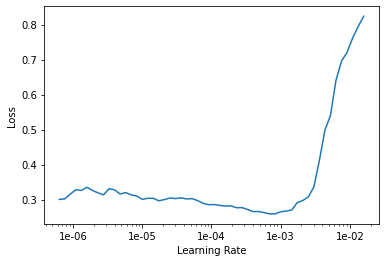

In [17]:
learn.recorder.plot()

In [18]:
learn.fit_one_cycle(2,max_lr=slice(1e-5,1e-3))

epoch,train_loss,valid_loss,error_rate,time
0,0.318564,0.378177,0.116667,00:16
1,0.248814,0.365163,0.100000,00:16


In [19]:
learn.save('second_train')

We will check if the training has been good or not

In [20]:
interp = ClassificationInterpretation.from_learner(learn)

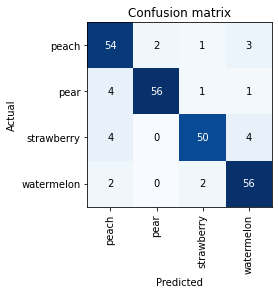

In [21]:
interp.plot_confusion_matrix()


## Dataset cleaning

We have a few utilities on fastai that help cleaning datasets (in a DataBunch), specially removing images, etc. 



In [23]:
from fastai.widgets import *

In [24]:
db = (ImageList.from_folder(path).split_none().label_from_folder().transform(get_transforms(),size=224).databunch())

In [25]:
ds, idx = DatasetFormatter().from_toplosses(learn)

In [26]:
ImageCleaner(ds, idx, path)

Button(button_style='primary', description='Next Batch', layout=Layout(width='auto'), style=ButtonStyle())

In [27]:
ds, idx = DatasetFormatter().from_similars(learn)

Getting activations...


Computing similarities...


In [28]:
ImageCleaner(ds, idx, path, duplicates=True)

Button(button_style='primary', description='Next Batch', layout=Layout(width='auto'), style=ButtonStyle())